In [1]:
import tensorflow as tf
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-11 15:50:32.417625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Create random data between (-10, 10) and determine groundtruth
simulatedInput = 20 * torch.rand((1000, 1)) - 10
groundTruth = np.cos(simulatedInput)

In [3]:
# Calculate the number of parameters in a neural network
def calcParams(inputModel):
    val = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return val

In [4]:
# Set up NN for cos(x) training - 2 Hidden Layers, 32 parameters - Shallow Network
class OptimizeNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [5]:
# Set up necessary auxilaries for neural net training
optimNet = OptimizeNN()
costFunc = nn.MSELoss()
opt = optim.Adam(optimNet.parameters(), lr=0.01)

In [6]:
# def calculate_grad_norm(model, criterion, train, target):
#     model.train()
#     model.zero_grad()
#     output = model(train)
#     loss = criterion(output, target)
#     loss.backward()

#     grads = []
#     for p in model.modules():
#         if isinstance(p, nn.Linear):
#             param_norm = p.weight.grad.norm(2).item()
#             grads.append(param_norm)

#     grad_mean = np.mean(grads) # compute mean of gradient norms
#     return grad_mean,loss

In [7]:
def min_ratio(w):
    count = 0
    total = 0
    for x in w:
        if(x>0):
            count += 1
        total +=1
    return count/ total

In [8]:
def calculate_grad_norm(model):
#     model.train()
#     model.zero_grad()
#     output = model(train)
#     loss = criterion(output, target)
#     loss.backward()

    grads = []
    for p in model.modules():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms
    return grad_mean

In [9]:
minRatio = []
Loss = []
train_count = 100
for i in range(train_count):
    EPOCHS = 30
    lss = 0
    # Set up necessary auxilaries for neural net training
    optimNet = OptimizeNN()
    costFunc = nn.MSELoss()
    opt = optim.Adam(optimNet.parameters(), lr=0.01)
    for epochIndex in range(EPOCHS):
        optimNet.zero_grad()
        output = optimNet(simulatedInput)
        cost = costFunc(output, groundTruth)
        with torch.no_grad():
            lss += (costFunc(output, groundTruth))
        cost.backward()
        opt.step()
    #print(calculate_grad_norm(optimNet))
    Loss.append(lss/len(simulatedInput))
    num_param = calcParams(optimNet)
    
    # Allocate Hessian size
    H = torch.zeros((num_param, num_param))

    y_hat = optimNet(simulatedInput)
    y = simulatedInput
    loss  = ((y_hat - y)**2).mean()
    # Calculate Jacobian w.r.t. model parameters
    J = torch.autograd.grad(loss, list(optimNet.parameters()), create_graph=True)
    J = torch.cat([e.flatten() for e in J]) # flatten

    # Fill in Hessian
    num_param = calcParams(optimNet)
    for i in range(num_param):
        result = torch.autograd.grad(J[i], list(optimNet.parameters()), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result]) # flatten
    w, v = np.linalg.eig(H)
    minRatio.append(min_ratio(w))
    #print(min_ratio(w))

In [10]:
#costFunc1 = calculate_grad_norm(optimNet, costFunc, simulatedInput, groundTruth)

In [11]:
# EPOCHS = 30
# for epochIndex in range(EPOCHS):
#     optimNet.zero_grad()
#     output = optimNet(simulatedInput)
#     cost =  torch.from_numpy(calculate_grad_norm(optimNet))
#     cost.backward()
#     opt.step()

In [12]:
calculate_grad_norm(optimNet)

0.0317182457074523

In [13]:
num_param = calcParams(optimNet)

In [14]:

# Allocate Hessian size
H = torch.zeros((num_param, num_param))

y_hat = optimNet(simulatedInput)
y = simulatedInput
loss  = ((y_hat - y)**2).mean()
# Calculate Jacobian w.r.t. model parameters
J = torch.autograd.grad(loss, list(optimNet.parameters()), create_graph=True)
J = torch.cat([e.flatten() for e in J]) # flatten

# Fill in Hessian
for i in range(num_param):
    result = torch.autograd.grad(J[i], list(optimNet.parameters()), retain_graph=True)
    H[i] = torch.cat([r.flatten() for r in result]) # flatten

In [15]:
# H.numpy().shape

In [16]:
# w, v = np.linalg.eig(H)
# w

In [17]:
# min_ratio(w)

Text(0, 0.5, 'Loss')

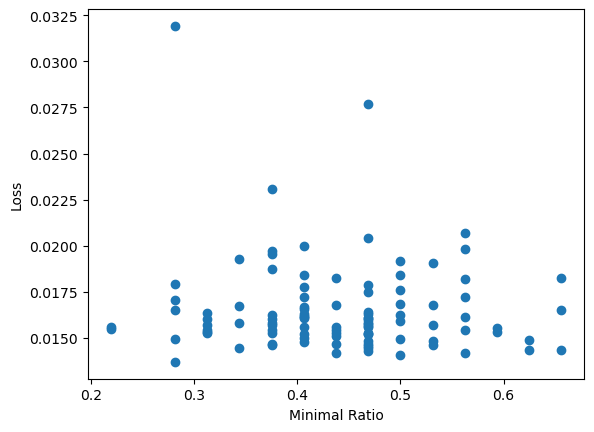

In [18]:
plt.scatter(minRatio, Loss)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')

In [19]:
len(simulatedInput)

1000